### Laboratorio 7 - Predicción de Diabetes con AutoGluon

Stefano Aragoni, Carol Arevalo 

------

El <font color=orange>objetivo de este ejercicio es construir, entrenar y probar un modelo clasificador para predecir diabetes en pacientes usando AutoGluon</font>. Esta herramienta puede ser utilizada de manera efectiva por profesionales de la salud para detectar diabetes y entender los factores clave que contribuyen a la enfermedad.

-------

En este laboratorio, se utilizó el dataset diabetes.csv, el cual contiene 9 columnas y 768 registros. La columna Outcome es la variable objetivo, la cual indica si el paciente tiene diabetes o no. Las otras 8 columnas son variables independientes que se utilizarán para predecir la variable objetivo.

##### *Importar librerías*

Como primer paso, se importaron las librerías necesarias para el desarrollo del laboratorio.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor


-----------

##### *Cargar el Conjunto de Datos*

Posteriormente, se cargó el conjunto de datos diabetes.csv en un dataframe de pandas. Como se puede observar, hay presentes 9 columnas. La columna Outcome es la variable objetivo, la cual indica si el paciente tiene diabetes o no. Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction y Age son las variables que se utilizarán para predecir la variable objetivo.

In [3]:
# Crear un DataFrame con el contenido
df = pd.read_csv('diabetes.csv')

# Explorar las primeras 5 filas del DataFrame
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


----------

##### *Análisis Exploratorio de Datos (EDA)*

Como primer paso del análisis exploratorio, se <font color=orange>obtuvo estadísticas descriptivas básicas de las variables del conjunto de datos</font>. 

En este caso, se puede observar valores normales y esperados. Sin emabrgo, en algunas columas se puede observar que hay valores que no tienen sentido. Por ejemplo, la presión sanguínea no puede ser 0. Asimismo, el BMI no puede ser 0. 

In [4]:
# Estadísticas descriptivas básicas
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Asimismo, como se puede observar, todos las columnas almacenan valores numéricos, por lo que no es necesario realizar un proceso de codificación de variables categóricas.

In [5]:
# Obtener información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Como segundo paso, se realizó una <font color=orange>visualización de la distribución de las variables del conjunto de datos</font>. 


Nuevamente, se pueden observar ciertos datos atípicos. Por ejemplo, BloodPressure, Glucose, BMI tienen valores con 0. Esto no es posible, por lo que se deben limpiar los datos.

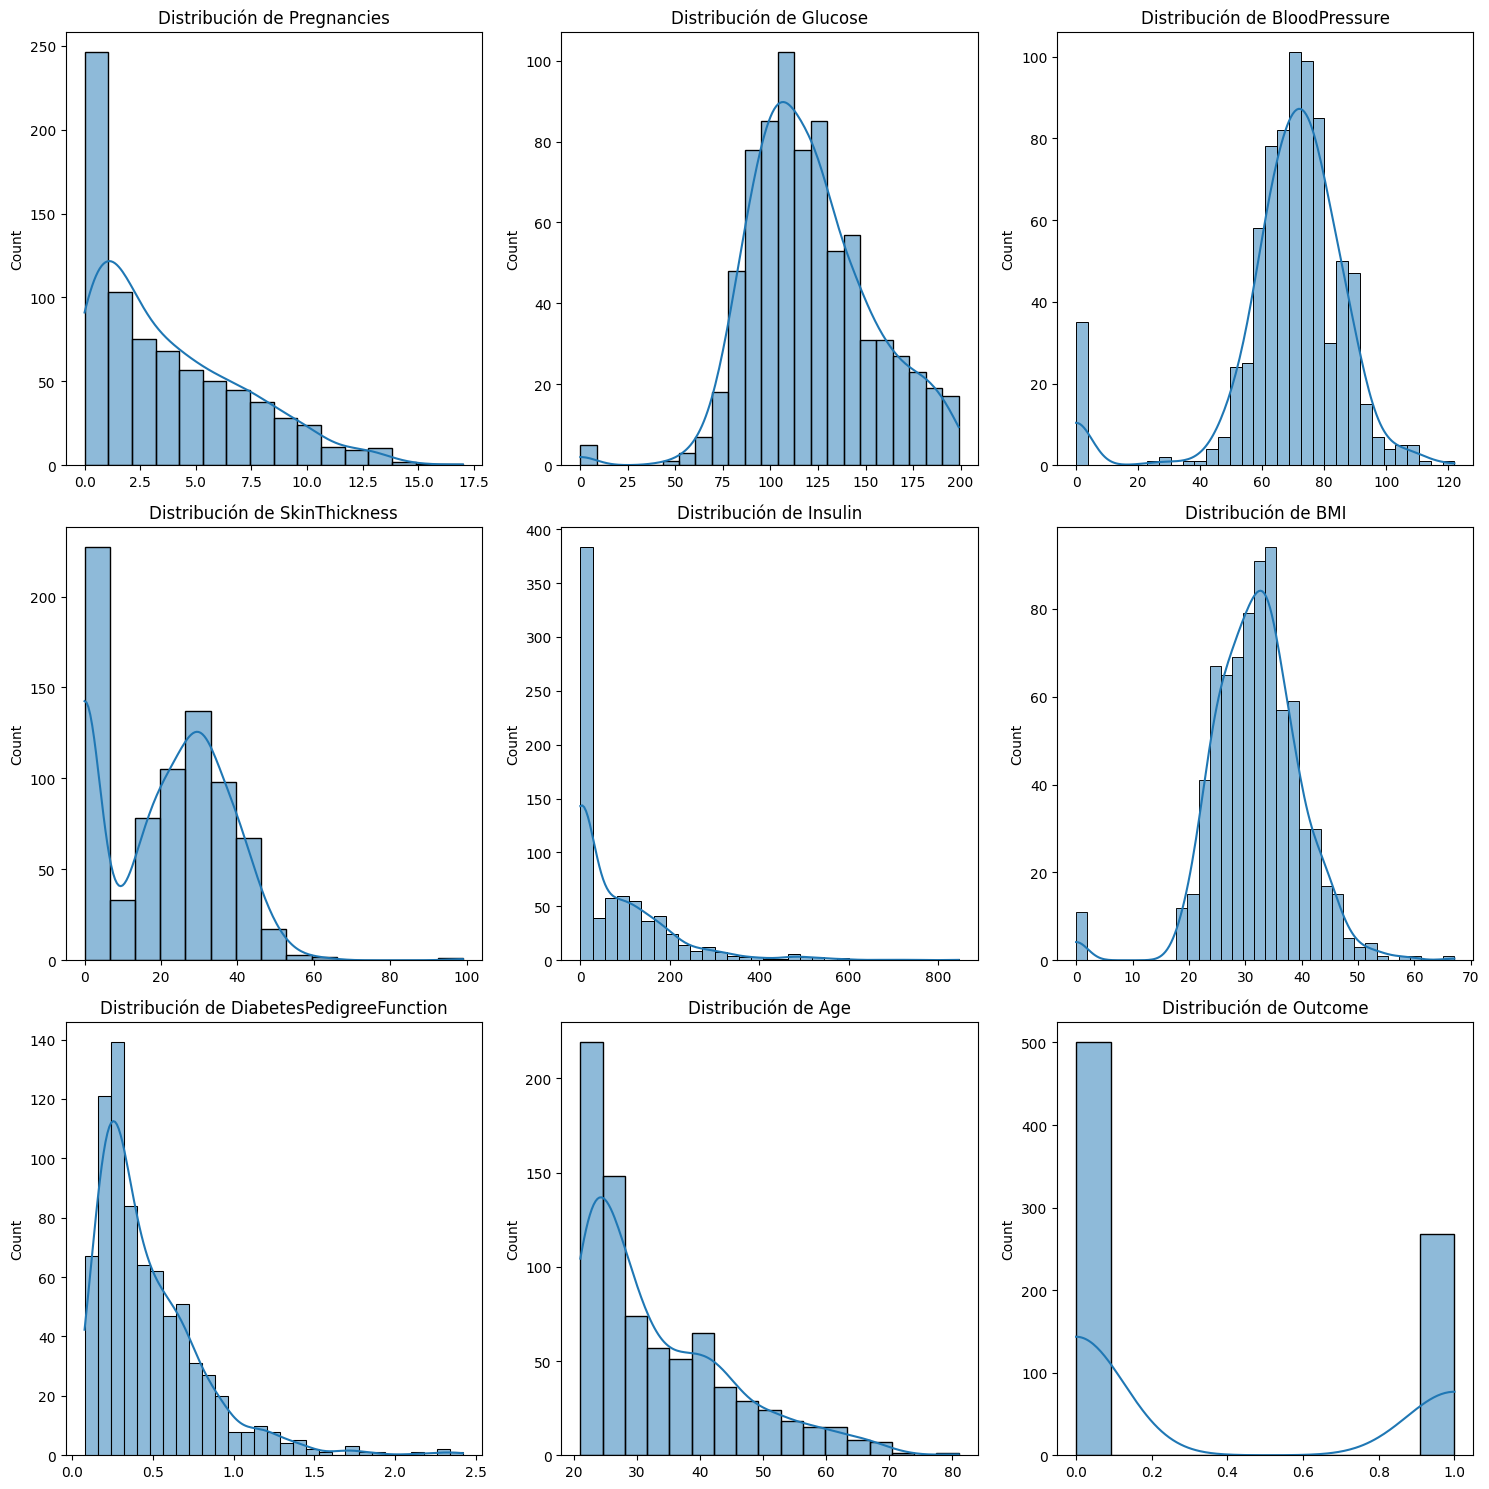

In [6]:
# Graficar la distribución de cada variable

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
df_values = df.values
columns = df.columns

# Iterar a través de las filas y columnas de la cuadrícula
for i in range(3):
    for j in range(3):
        column = columns[i * 3 + j]
        sns.histplot(df_values[:, i * 3 + j], kde=True, ax=axes[i, j])
        axes[i, j].set_title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

Tomando en cuenta lo que se observó en el análisis exploratorio de datos, se procedió a limpiar los datos.
Más específicamente, se remplazó los valores 0 por NaN en las columnas Glucose, BloodPressure, y BMI.

In [9]:
# Reemplazar los valores 0 por NaN en las columnas Glucose, BloodPressure, y BMI

df[['Glucose', 'BloodPressure', 'BMI']] = df[['Glucose', 'BloodPressure', 'BMI']].replace(0, np.nan)

Como tercer y último paso, se <font color=orange>verificó que no existan valores nulos en el conjunto de datos</font>. Sin embargo, debido a que se remplazó los valores 0 por NaN, se puede observar que hay valores nulos en las columnas Glucose, BloodPressure, y BMI.

Porcentaje de filas con valores nulos:
5.729166666666666


<AxesSubplot: >

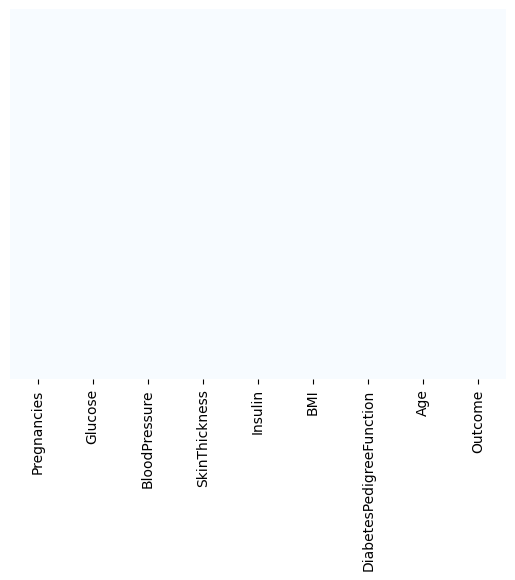

In [14]:
# % de filas con valores nulos
print('Porcentaje de filas con valores nulos:')
print(df.isnull().any(axis=1).sum() / len(df) * 100)


# Eliminar las filas con valores nulos
df = df.dropna()


# Verificación de valores nulos
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [ ]:
# Ver datos atipicos
sns.boxplot(data=df, orient='h', palette='Set2')

: 

In [ ]:
# realizar una gráfica pairplot

sns.pairplot(df)

: 

3. Entrenamiento con AutoGluo

In [ ]:
# Dividir los datos en un 80% para entrenamiento y 20% para pruebas

X_entreno, X_prueba = train_test_split(df, test_size=0.2, random_state=0)
X_entreno
X_prueba

: 

In [ ]:
predictor = TabularPredictor(label="charges", 
                             problem_type = 'regression', 
                             eval_metric = 'r2').fit(train_data = X_entreno, 
                                                     time_limit = 200, 
                                                     presets = "best_quality")


: 

In [ ]:
predictor.fit_summary()

: 

4. Evaluación del Modelo:


In [ ]:
predictor.leaderboard()

: 

In [ ]:
# Inicializar la figura de matplotlib

f, ax = plt.subplots(figsize = (15, 6))
sns.barplot(x = "model", y = "score_val", data = predictor.leaderboard(), color = "b")
ax.set(ylabel = "Performance Metric (R2)", xlabel = "Regression Models")
plt.xticks(rotation = 45);

: 

In [ ]:
predictor.evaluate(X_prueba)

: 

In [ ]:
# Evaluar el rendimiento de los modelos
# Seleccionar 5 observaciones del conjunto de datos de prueba y generar las predicciones

y_pred = predictor.predict(X_prueba)
print("Predictions:  ", list(y_pred)[:5])

: 

In [ ]:
y_predicc = predictor.predict(X_prueba)
plt.figure(figsize = (15, 10))
plt.plot(y_prueba, y_predicc, "^", color = 'r')
plt.ylabel('Predicciones de los modelos')
plt.xlabel('Valores reales')

: 

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_prueba, y_predicc)),'.3f'))
MSE = mean_squared_error(y_prueba, y_predicc)
MAE = mean_absolute_error(y_prueba, y_predicc)
r2 = r2_score(y_prueba, y_predicc)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2) 

: 

5. Reflexión:
